In [2]:
#   bem: triangulation and fmm/bem electrostatics tools 
#
#   Copyright (C) 2011-2012 Robert Jordens <jordens@gmail.com>
#
#   This program is free software: you can redistribute it and/or modify
#   it under the terms of the GNU General Public License as published by
#   the Free Software Foundation, either version 3 of the License, or
#   (at your option) any later version.
#
#   This program is distributed in the hope that it will be useful,
#   but WITHOUT ANY WARRANTY; without even the implied warranty of
#   MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#   GNU General Public License for more details.
#
#   You should have received a copy of the GNU General Public License
#   along with this program.  If not, see <http://www.gnu.org/licenses/>.

# `bem` 3D electrostatics example

In [3]:
import sys
import logging, os
from time import time
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../../')
sys.path.append('../../../electrode/')

from bem import Electrodes, Sphere, Mesh, Grid, Configuration, Result
from bem.formats import stl

In [4]:
# base file name for outputs and inputs is the script name
try:
    # works only if we are a script
    prefix = os.path.splitext(__file__)[0]
except NameError:
    # fallback for notebooks
    prefix = "SimpleTrap"

In [5]:
# scale to natural units (ion height)
scale = 40e-6
use_stl = True

if not use_stl:
    # load electrode faces from loops
    ele = Electrodes.from_trap(open("%s.ele" % prefix), scale)
    # initial triangulation, area 20, quiet
    mesh = Mesh.from_electrodes(ele)
    mesh.triangulate(opts="qa10Q")
else:
    # load electrode faces from colored stl
    s = stl.read_stl(open("%s.stl" % prefix, "rb"))
    mesh = Mesh.from_mesh(stl.stl_to_mesh(*s, scale=scale/1e-6,
        rename={9495: "DC1", 17962: "DC3", 18994: "DC5",
        18869: "DC2", 20943: "RF", 18129: "DC4"}))

dropping 0


In [6]:
def run_job(args):
    job, grid, prefix = args
    # refine twice adaptively with increasing number of triangles, min
    # angle 25deg
    job.adapt_mesh(triangles=4e2, opts="q25Q")
    job.adapt_mesh(triangles=1e3, opts="q25Q")
    # solve for charges
    job.solve_singularities(num_mom=4, num_lev=3)
    # get potentials and fields
    result = job.simulate(grid, field=job.name=="RF", num_lev=1)
    result.to_vtk(prefix)
    print("finished job %s" % job.name)
    return job.collect_charges()

In [7]:
# set .1 max area within 3
mesh.areas_from_constraints(Sphere(center=np.array([0, 0, 1.]),
           radius=2, inside=.2, outside=10.))
# retriangulate quality and quiet with areas
mesh.triangulate(opts="qQ", new=False)
# save base mesh to vtk
mesh.to_vtk(prefix)
# grid to evalute potential and fields at
n, s = 2*10, .1
grid = Grid(center=(0, 0, 1.5), step=(s, s, s), shape=(n, n, n))
# generate electrode potential configurations to simulate
# use regexps to match electrode names
jobs = list(Configuration.select(mesh, "DC.*", "RF"))
# run the different electrodes on the parallel pool
#pmap = Pool().map # parallel map
pmap = map # serial map
t0 = time()
list(pmap(run_job, ((job, grid, prefix) for job in jobs)))  # In python 3, convert map(...) to list(map(...))
print("Computing time: %f s"%(time()-t0))

start triangulate DC1
('final opts', 'qQzra')
finish triangulate DC1
start triangulate DC3
('final opts', 'qQzra')
finish triangulate DC3
start triangulate DC5
('final opts', 'qQzra')
finish triangulate DC5
start triangulate DC2
('final opts', 'qQzra')
finish triangulate DC2
start triangulate RF
('final opts', 'qQzra')
finish triangulate RF
start triangulate DC4
('final opts', 'qQzra')
finish triangulate DC4
FLW-placeq: oversized panel, cube length=2.28302 panel length=3.16826
FLW-placeq: oversized panel, cube length=2.28302 panel length=3.16826
FLW-placeq: oversized panel, cube length=2.28302 panel length=3.02951
FLW-placeq: oversized panel, cube length=2.28302 panel length=2.54384
FLW-placeq: oversized panel, cube length=2.28302 panel length=3.31789
FLW-placeq: oversized panel, cube length=2.28302 panel length=3.31789
FLW-placeq: oversized panel, cube length=2.28302 panel length=3.31789
FLW-placeq: oversized panel, cube length=2.28302 panel length=2.59616
FLW-placeq: oversized panel,

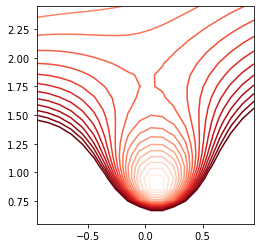

In [8]:
# isocontour plot of the RF pseudopotential radially
result = Result.from_vtk(prefix, "RF")
p = result.pseudo_potential
x = grid.to_mgrid()[:, p.shape[0]//2]    # In python 3, use //
p = p[p.shape[0]//2]
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[1], x[2], p, levels=np.linspace(0, 2e-2, 20), cmap=plt.cm.Reds)

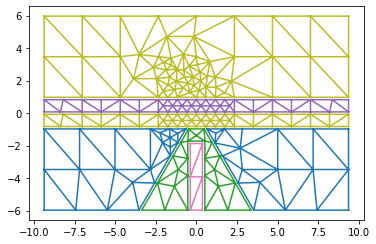

In [9]:
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
mesh.plot(ax)

In [10]:
# explore it in fancy 3D
# fire up a mayavi2 window showing base mesh, charges on final mesh
# and isosurfaces of the pseudopotential
Result.view(prefix, "RF")
# need to start the full eventloop for the window.
# close it to return control to the notebook
from pyface.api import GUI
GUI().start_event_loop()

qt.qpa.window: <QNSWindow: 0x7fc23202a720; contentView=<QNSView: 0x7fc23202a310; QCocoaWindow(0x6000016806e0, window=QWidgetWindow(0x6000005a29a0, name="QMainWindowClassWindow"))>> has active key-value observers (KVO)! These will stop working now that the window is recreated, and will result in exceptions when the observers are removed. Break in QCocoaWindow::recreateWindowIfNeeded to debug.


In [11]:
from electrode import System, GridElectrode

# load the electrostatics results into a electrode.System()
s = System()
for name in "DC1 DC2 DC3 DC4 DC5 RF".split():
    r = Result.from_vtk(prefix, name)
    e = GridElectrode.from_result(r)
    e.name = name
    s.append(e)

ModuleNotFoundError: No module named 'electrode'

In [ ]:
import scipy.constants as ct
l = 40e-6 # length scale
o = 100e6*2*np.pi # rf frequency
m = 25*ct.atomic_mass # ion mass
q = 1*ct.elementary_charge # ion charge
rf_scale = s.rf_scale(m,q,l,o)

s["RF"].rf = 25. # peak rf voltage
method = 'Newton-CG'
x0 = s.minimum((0, 0, 1.),method=method)
for _ in s.analyze_static(x0, m=m, l=l, o=o, min_method=method):
    print(_)

: 

In [ ]:
n = 30
#xyz = np.mgrid[-.1:.1:1j*n, -.1:.1:1j*n, 1.12:2]
#xyz = np.mgrid[0:1, -.02:.02:1j*n, .5:1.5:1j*n]
xyz = grid.to_mgrid()
p = s.potential(xyz.reshape(3, -1).T, 0).reshape(xyz[0].shape)
v = np.linspace(0, 2e-2, 21)
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(xyz[1, 10, :, :], xyz[2, 10, :, :], p[10, :, :], v, cmap=plt.cm.Reds_r)

: 

: 